In [1]:
import numpy as np
from scipy.stats import ks_2samp
from scipy import stats
import matplotlib.pyplot as plt
import h5py

import sys
sys.path.append('../py_files/')
#import weights
import control_sample as control

In [2]:
import os
tex_path = '/apps/texlive/2023/bin/x86_64-linux/'
os.environ['PATH'] += os.pathsep + tex_path

In [3]:
import scienceplots
plt.style.use('science')

In [4]:
#pop_file_loc = "/home/pranavsatheesh/host_galaxies/data/population_files/"
pop_file_loc = "/home/pranavsatheesh/host_galaxies/data/population_files/new/"
#pop_file = pop_file_loc + "population_sort_gas-100_dm-100_star-100_bh-001_w_rsep_cut_1bh.hdf5"
pop_file = pop_file_loc + "population_sort_gas-000_dm-000_star-1000_bh-000_w_rsep_cut_1bh.hdf5"
# pop_file = pop_file_loc + "population_sort_gas-100_dm-100_star-100_bh-001_w_rsep_cut.hdf5"

pop = h5py.File(pop_file, 'r')

In [5]:
pop['merging_population'].keys()

<KeysViewHDF5 ['MBH', 'MBH_1', 'MBH_2', 'MBH_final', 'Mdot', 'Mgas', 'Mstar', 'SFR', 'q_merger', 'rsep', 'snap', 'subhalo_ids', 'z']>

In [8]:
#control.control_samples(pop)

### A different matching technique

In [9]:
merging_points = np.column_stack((pop['merging_population']['z'], np.log10(pop['merging_population']['Mstar'])))
non_merging_points = np.column_stack((pop['non_merging_population']['z'], np.log10(pop['non_merging_population']['Mstar'])))

In [10]:
from scipy.spatial import cKDTree
from scipy.stats import ks_2samp
tree = cKDTree(non_merging_points)

In [11]:
tree.query(merging_points[0],k=1)

(0.007215320746071896, 0)

In [12]:
from tqdm import tqdm

In [13]:
merging_points = np.column_stack((pop['merging_population']['z'], np.log10(pop['merging_population']['Mstar'])))

non_merging_points = np.column_stack((pop['non_merging_population']['z'], np.log10(pop['non_merging_population']['Mstar'])))

tree = cKDTree(non_merging_points)
used = np.zeros(len(non_merging_points), dtype=bool)

control_indices = []

while True:
    closest_indices = np.full(len(merging_points), -1)
    
    tolerances = []
    for i in tqdm(range(len(merging_points)), desc="Processing merging points", ncols=100):
        #find the closest neibhour 
        dist, min_idx = tree.query(merging_points[i])
        if(used[min_idx]):
            dists,idxs = tree.query(merging_points[i],k=len(non_merging_points))
            min_idx = idxs[np.where(~used[idxs])[0][0]] 

        #check for tolerance:
        del_z = np.abs(merging_points[i][0]-non_merging_points[min_idx][0])
        dex_Mstar = np.abs(np.log10(merging_points[i][1]/non_merging_points[min_idx][1]))

        z_tolerance = 0.05
        Mstar_dex_tolerance = 0.1

        while True:
            if(del_z<z_tolerance and dex_Mstar<Mstar_dex_tolerance):
                used[min_idx] = True
                closest_indices[i] = min_idx
                tolerances.append((z_tolerance, Mstar_dex_tolerance))
                break
            else:
                z_tolerance = z_tolerance*1.5
                Mstar_dex_tolerance = Mstar_dex_tolerance*1.5
                if(z_tolerance>0.6 or Mstar_dex_tolerance>0.6):
                    print("Could not find a match for merging point:", i)
                    print(del_z, dex_Mstar)
                    print("Last tolerances:", z_tolerance, Mstar_dex_tolerance)
                    closest_indices[i] = -1
                    break

    control_indices.append(closest_indices)
        #D_mstar, p_Mstar = ks_2samp(pop['non_merging_population']['Mstar'][np.sort(closest_indices)],pop['merging_population']['Mstar'])
        #D_z, p_z = ks_2samp(pop['non_merging_population']['z'][np.sort(closest_indices)],pop['merging_population']['z'])
        
        #print(p_z,p_Mstar,np.shape(control_indices)[0])
        #print(z_tolerance,Mstar_dex_tolerance)

    if np.shape(control_indices)[0]>=1:
        break


Processing merging points:   4%|█▍                              | 126/2904 [00:00<00:13, 213.14it/s]

Could not find a match for merging point: 110
0.2991708468230323 0.013729465783049684
Last tolerances: 0.37968750000000007 0.7593750000000001


Processing merging points:  25%|███████▊                        | 713/2904 [00:05<00:11, 184.56it/s]

Could not find a match for merging point: 712
0.2805803999754173 0.0028707706112670937
Last tolerances: 0.37968750000000007 0.7593750000000001


Processing merging points:  61%|██████████████████▉            | 1772/2904 [00:15<00:05, 212.02it/s]

Could not find a match for merging point: 1675
0.26546819233273466 0.003481347843635414
Last tolerances: 0.37968750000000007 0.7593750000000001


Processing merging points:  62%|███████████████████▎           | 1808/2904 [00:15<00:04, 230.53it/s]

Could not find a match for merging point: 1795
0.2543938493709694 0.009675176885887272
Last tolerances: 0.37968750000000007 0.7593750000000001


Processing merging points: 100%|███████████████████████████████| 2904/2904 [00:17<00:00, 163.65it/s]


In [14]:
np.argwhere(np.array(control_indices)==-1)[:,1]

array([ 110,  712, 1675, 1795])

In [15]:
valid_control_mask = control_indices[0]!=-1

In [16]:
control_indices[0][valid_control_mask]

array([     0,    189,    436, ..., 699879, 706652, 704782])

### Check the control vs mergers match 

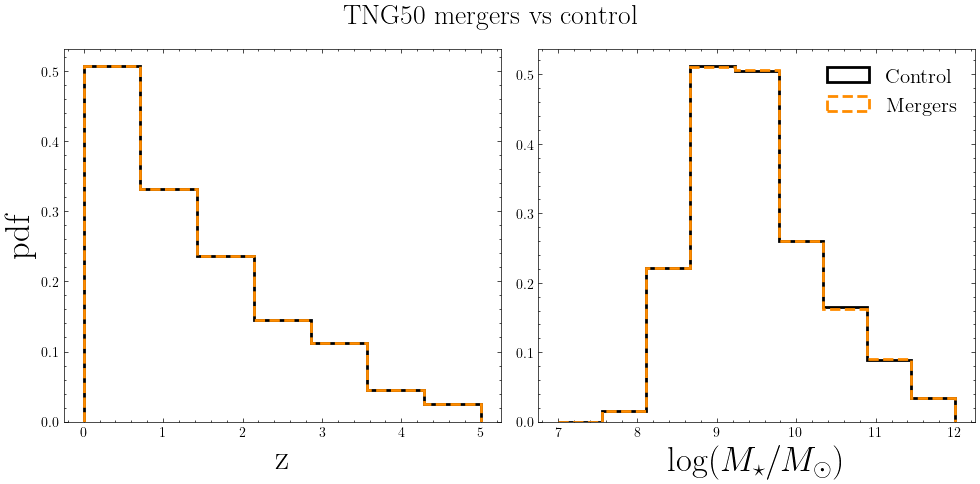

In [22]:
Mstar_binsize = 0.5
Mstar_min = 7
Mstar_max = 12
Nbins_Ms = int((Mstar_max - Mstar_min) / Mstar_binsize)
Mstar_bins = np.linspace(Mstar_min, Mstar_max, Nbins_Ms)

z_binsize = 0.6
z_min = 0
z_max = 5
Nbins_z = int((z_max - z_min) / z_binsize)
z_bins = np.linspace(z_min, z_max, Nbins_z )

fig,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].hist(pop['non_merging_population']['z'][:][control_indices[0][valid_control_mask]], bins=z_bins, color="black", histtype="step",linewidth=2,density=True)
ax[0].hist(pop['merging_population']['z'][valid_control_mask], bins=z_bins, histtype="step",color="Darkorange",linestyle="--",linewidth=2,density=True)
ax[0].set_xlabel("z",fontsize=25)
ax[0].set_ylabel("pdf",fontsize=25)
ax[0].set_xticks([0,1,2,3,4,5])


ax[1].hist(np.log10(pop['non_merging_population']['Mstar'][:][control_indices[0][valid_control_mask]]), bins=Mstar_bins,histtype="step",color="black",label="Control",linewidth=2,density=True)
ax[1].hist(np.log10(pop['merging_population']['Mstar'][valid_control_mask]),bins=Mstar_bins,histtype="step",label="Mergers",color="Darkorange",linestyle="--",linewidth=2,density=True)
ax[1].set_xticks([7,8,9,10,11,12])
ax[1].legend(fontsize=15)
ax[1].set_xlabel("$\log(M_{\star}/M_{\odot})$",fontsize=25)

fig.suptitle("TNG50 mergers vs control",fontsize=20)
fig.tight_layout()
fig.savefig("../figures/TNG50_mergers_vs_control_1000_stellar_particles.pdf",dpi=300)

### Properties of Mergers vs Control

In [23]:
z_merging_pop = pop['merging_population']['z'][:][valid_control_mask]
z_control_pop = pop['non_merging_population']['z'][:][control_indices[0][valid_control_mask]]

Mstar_merging_pop = pop['merging_population']['Mstar'][:][valid_control_mask]
Mstar_control_pop = pop['non_merging_population']['Mstar'][:][control_indices[0][valid_control_mask]]

MBH_merging_pop = pop['merging_population']['MBH'][:][valid_control_mask]
MBH_control_pop = pop['non_merging_population']['MBH'][:][control_indices[0][valid_control_mask]]

SFR_merging_pop = pop['merging_population']['SFR'][:][valid_control_mask]
SFR_control_pop = pop['non_merging_population']['SFR'][:][control_indices[0][valid_control_mask]]

sSFR_merging_pop = SFR_merging_pop/Mstar_merging_pop
sSFR_control_pop = SFR_control_pop/Mstar_control_pop

Mgas_merging_pop = pop['merging_population']['Mgas'][:][valid_control_mask]
Mgas_control_pop = pop['non_merging_population']['Mgas'][:][control_indices[0][valid_control_mask]]

fgas_merging_pop = Mgas_merging_pop/(Mgas_merging_pop+Mstar_merging_pop)
fgas_control_pop = Mgas_control_pop/(Mgas_control_pop+Mstar_control_pop)

Mdot_merging_pop = pop['merging_population']['Mdot'][:][valid_control_mask]
Mdot_control_pop = pop['non_merging_population']['Mdot'][:][control_indices[0][valid_control_mask]]

In [24]:
bin_settings = {
            'sSFR': {'binsize': 0.2, 'bin_min': -14, 'bin_max': -7},
            'Mgas': {'binsize': 0.2, 'bin_min': 5, 'bin_max': 14},
            'fgas': {'binsize': 0.05, 'bin_min': 0, 'bin_max': 1},
            'Mdot': {'binsize': 0.2, 'bin_min': -8, 'bin_max': 1},
            }

In [25]:
properties = {
            'sSFR': (np.log10(sSFR_merging_pop[sSFR_merging_pop > 0]), np.log10(sSFR_control_pop[sSFR_control_pop > 0])),
            'Mdot': (np.log10(Mdot_merging_pop[Mdot_merging_pop > 0]), np.log10(Mdot_control_pop[Mdot_control_pop > 0]))
        }

In [26]:
properties_xlabel = {
            'sSFR': r"$\log_{10}(\mathrm{sSFR}[\mathrm{yr}^{-1}])$",
            'Mdot': r"$\log_{10}(\dot{M}_{\mathrm{BH}}[M_{\odot}\, \mathrm{yr}^{-1}])$",
            'Mgas': r"$\log_{10}(M_{\mathrm{gas}}[M_{\odot}])$",
            'fgas': r"$f_{\mathrm{gas}}$",
            }

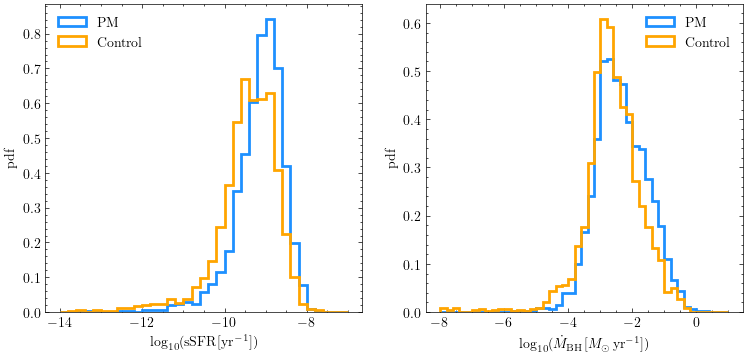

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))
axes = axes.flatten()

for i, (prop_name, (prop_merging, prop_control)) in enumerate(properties.items()):
    binsize = bin_settings[prop_name].get('binsize')
    bin_min = bin_settings[prop_name].get('bin_min')
    bin_max = bin_settings[prop_name].get('bin_max')
    bins = np.arange(bin_min, bin_max + binsize, binsize)
        
            # Plot histograms
    axes[i].hist(prop_merging, bins=bins,color='dodgerblue', label='PM', density=True,histtype="step", linewidth=2)
    axes[i].hist(prop_control, bins=bins,color='orange', label='Control', density=True,histtype="step", linewidth=2)
    axes[i].set_xlabel(properties_xlabel[prop_name])
    axes[i].set_ylabel('pdf')
    axes[i].legend()

### sSFR vs redshift

In [46]:
def set_plot_style(linewidth=3, titlesize=20,labelsize=25,ticksize=20,legendsize=20):
    """Set matplotlib rcParams for consistent plot style."""
    plt.rcParams.update({
        'lines.linewidth': linewidth,
        'axes.labelsize': labelsize,
        'axes.titlesize': titlesize,
        'xtick.labelsize': ticksize,
        'ytick.labelsize': ticksize,
        'legend.fontsize': legendsize
    })

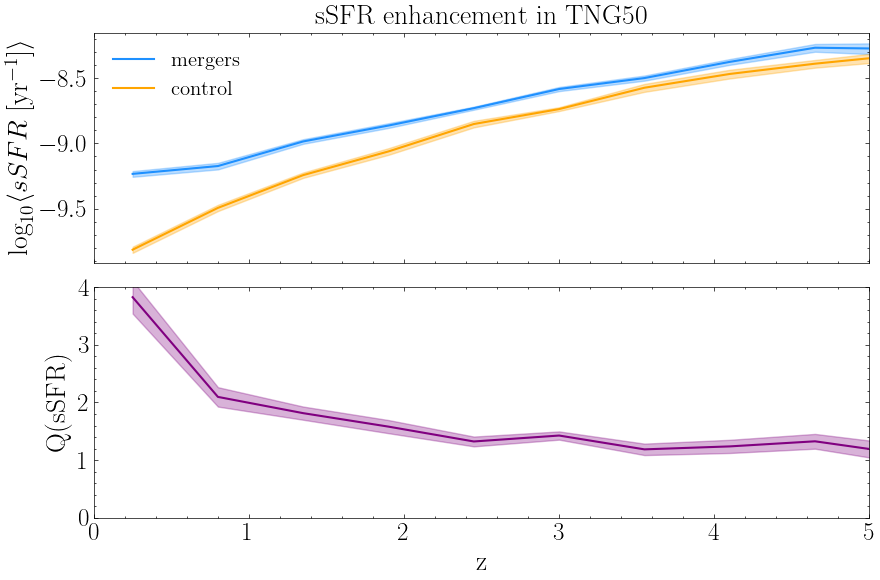

In [86]:
z_min = 0
z_max = 5.5
z_binsize = 0.5

Nbins_z = int((z_max - z_min) / z_binsize)
z_bins = np.linspace(z_min, z_max, Nbins_z)

avg_sSFR_control = []
std_sSFR_control = []

avg_sSFR_merger = []
std_sSFR_merger = []

# Loop through redshift bins
for i in range(len(z_bins) - 1):
    # Create masks for merging and control populations within each redshift bin
    merger_z_mask = (z_merging_pop > z_bins[i]) & (z_merging_pop < z_bins[i + 1])
    control_z_mask = (z_control_pop > z_bins[i]) & (z_control_pop < z_bins[i + 1])

    sSFR_merging_pop_filtered = sSFR_merging_pop[merger_z_mask]
    sSFR_control_pop_filtered = sSFR_control_pop[control_z_mask]

    avg_sSFR_merger.append(np.mean(sSFR_merging_pop_filtered))
    std_sSFR_merger.append(np.std(sSFR_merging_pop_filtered) / np.sqrt(len(sSFR_merging_pop_filtered)))

    avg_sSFR_control.append(np.mean(sSFR_control_pop_filtered))
    std_sSFR_control.append(np.std(sSFR_control_pop_filtered) / np.sqrt(len(sSFR_control_pop_filtered)))

avg_sSFR_merger = np.array(avg_sSFR_merger)
std_sSFR_merger = np.array(std_sSFR_merger)

avg_sSFR_control = np.array(avg_sSFR_control)
std_sSFR_control = np.array(std_sSFR_control)

Q_sSFR = avg_sSFR_merger / avg_sSFR_control
Q_sSFR_SE = Q_sSFR * np.sqrt((std_sSFR_merger / avg_sSFR_merger) ** 2 + (std_sSFR_control / avg_sSFR_control) ** 2)

# Plot the results
set_plot_style(linewidth=1.5,labelsize=25,ticksize=18,legendsize=20)
fig, ax = plt.subplots(2, 1, figsize=(9,6),sharex=True)
ax[0].plot(z_bins[:-1] + z_binsize / 2, np.log10(avg_sSFR_merger[avg_sSFR_merger > 0]), label='mergers', color="dodgerblue")
ax[0].fill_between(z_bins[:-1] + z_binsize / 2, np.log10(avg_sSFR_merger - std_sSFR_merger), np.log10(avg_sSFR_merger + std_sSFR_merger), alpha=0.3, color='dodgerblue')
ax[0].plot(z_bins[:-1] + z_binsize / 2, np.log10(avg_sSFR_control[avg_sSFR_control > 0]), label='control', color='orange')
ax[0].fill_between(z_bins[:-1] + z_binsize / 2, np.log10(avg_sSFR_control - std_sSFR_control), np.log10(avg_sSFR_control + std_sSFR_control), alpha=0.3, color='orange')
ax[0].legend(fontsize=15)
#ax[0].set_xlabel('z')
ax[0].set_ylabel(r'$\log_{10}\langle sSFR \; [\mathrm{yr}^{-1}]\rangle$',fontsize=20)

ax[1].plot(z_bins[:-1] + z_binsize / 2, Q_sSFR, color='purple')
ax[1].fill_between(z_bins[:-1] + z_binsize / 2, Q_sSFR - Q_sSFR_SE, Q_sSFR + Q_sSFR_SE, alpha=0.3, color='purple')
ax[1].set_xlabel('z',fontsize=20)
ax[1].set_ylabel('Q(sSFR)',fontsize=20)
ax[1].set_ylim(0, 4)
ax[1].set_xticks([0,1,2,3,4,5])
ax[1].set_xlim(0,5)
ax[0].set_xlim(0,5)
ax[0].set_title("sSFR enhancement in TNG50",fontsize=20)
#ax[1].axhline(y=1, color='gray', linestyle='--')
# Final layout adjustments
fig.tight_layout()
fig.savefig("../figures/TNG50_sSFR_enhancement_vs_z_1000_stellar_particles.pdf",dpi=300)

In [83]:
controlpop.set_plot_style(linewidth=3,labelsize=25,ticksize=20,legendsize=20)
fig,axes = controlpop.plot_sSFR_evolution()
fig.set_size_inches(8,9)
figure_loc = '../figures/sSFR_z_evolution_merger_vs_control.pdf'
fig.savefig(figure_loc)

NameError: name 'controlpop' is not defined

In [75]:
len(Mdot_merging_pop)

2904

### Mdot vs redshift

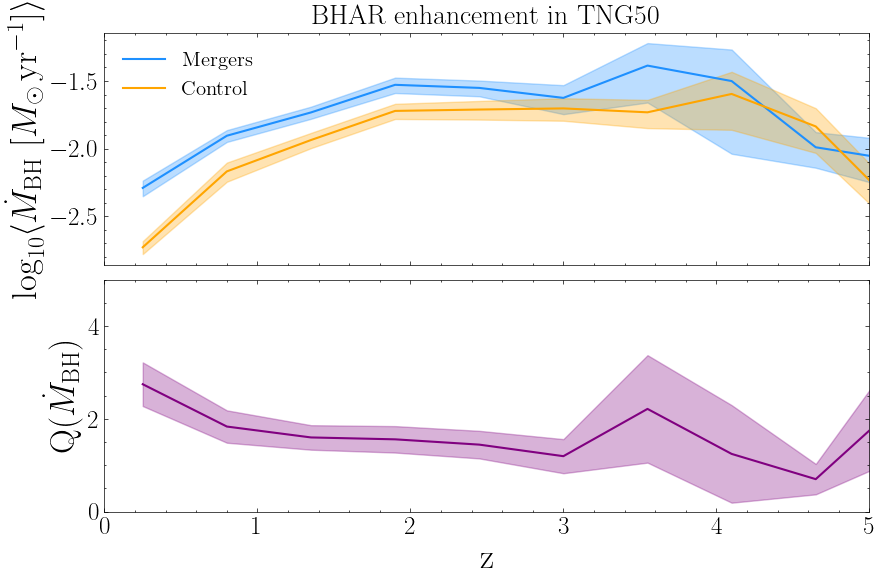

In [88]:
z_min = 0
z_max = 5.5
z_binsize = 0.5

Nbins_z = int((z_max - z_min) / z_binsize)
z_bins = np.linspace(z_min, z_max, Nbins_z)

avg_Mdot_control = []
std_Mdot_control = []

avg_Mdot_merger = []
std_Mdot_merger = []

# Loop through redshift bins
for i in range(len(z_bins) - 1):
    # Create masks for merging and control populations within each redshift bin
    merger_z_mask = (z_merging_pop > z_bins[i]) & (z_merging_pop < z_bins[i+1])
    control_z_mask = (z_control_pop > z_bins[i]) & (z_control_pop < z_bins[i+1])

    # Get the Mdot for each population
    Mdot_merging_pop_filtered = Mdot_merging_pop[merger_z_mask]
    Mdot_control_pop_filtered = Mdot_control_pop[control_z_mask]

    avg_Mdot_merger.append(np.mean(Mdot_merging_pop_filtered))
    std_Mdot_merger.append(np.std(Mdot_merging_pop_filtered) / np.sqrt(len(Mdot_merging_pop_filtered)))

    avg_Mdot_control.append(np.mean(Mdot_control_pop_filtered))
    std_Mdot_control.append(np.std(Mdot_control_pop_filtered) / np.sqrt(len(Mdot_control_pop_filtered)))

avg_Mdot_merger = np.array(avg_Mdot_merger)
std_Mdot_merger = np.array(std_Mdot_merger)

avg_Mdot_control = np.array(avg_Mdot_control)
std_Mdot_control = np.array(std_Mdot_control)

Q_Mdot = avg_Mdot_merger / avg_Mdot_control
Q_Mdot_SE = Q_Mdot * np.sqrt((std_Mdot_merger / avg_Mdot_merger) ** 2 + (std_Mdot_control / avg_Mdot_control) ** 2)

# Plot the results
set_plot_style(linewidth=1.5,labelsize=25,ticksize=18,legendsize=15)
fig, ax = plt.subplots(2, 1, figsize=(9, 6),sharex=True)
ax[0].plot(z_bins[:-1] + z_binsize / 2, np.log10(avg_Mdot_merger[avg_Mdot_merger > 0]), label='Mergers', color='dodgerblue')
ax[0].fill_between(z_bins[:-1] + z_binsize / 2, np.log10(avg_Mdot_merger - std_Mdot_merger), np.log10(avg_Mdot_merger + std_Mdot_merger), alpha=0.3, color='dodgerblue')

ax[0].plot(z_bins[:-1] + z_binsize / 2, np.log10(avg_Mdot_control[avg_Mdot_control > 0]), label='Control', color="orange")
ax[0].fill_between(z_bins[:-1] + z_binsize / 2, np.log10(avg_Mdot_control - std_Mdot_control), np.log10(avg_Mdot_control + std_Mdot_control), alpha=0.3, color='orange')

ax[0].legend(loc='upper left')
#ax[0].set_xlabel('z')
ax[0].set_ylabel(r'$\log_{10}\langle \dot{M}_{\mathrm{BH}} \; [M_{\odot} \, \mathrm{yr}^{-1}]\rangle$')

ax[1].plot(z_bins[:-1] + z_binsize / 2, Q_Mdot, color='purple')
ax[1].fill_between(z_bins[:-1] + z_binsize / 2, Q_Mdot - Q_Mdot_SE, Q_Mdot + Q_Mdot_SE, alpha=0.3, color='purple')
ax[1].set_xlabel('z')
ax[1].set_ylabel('Q($\dot{M}_{\mathrm{BH}}$)')
ax[1].set_ylim(0, 5)
ax[0].set_title("BHAR enhancement in TNG50",fontsize=20)
ax[0].set_xlim(0,5)
ax[1].set_xlim(0,5)
# Final layout adjustments
fig.tight_layout()
fig.savefig("../figures/TNG50_BHAR_enhancement_vs_z_1000_stellar_particles.pdf", dpi=300)

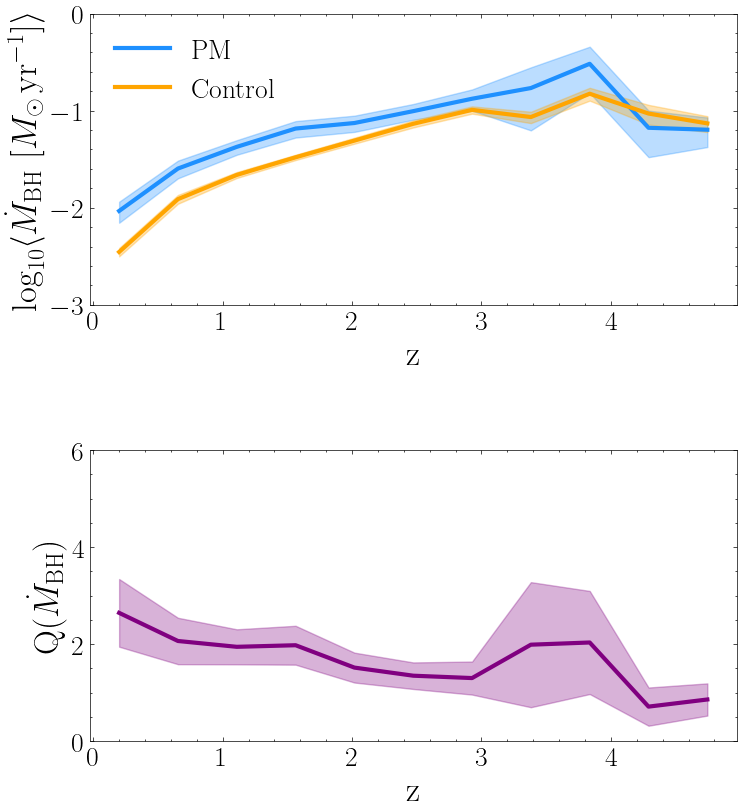

In [19]:
controlpop.set_plot_style(linewidth=3,labelsize=25,ticksize=20,legendsize=20)
fig,axes = controlpop.plot_mdot_evolution(z_min=0, z_max=5, z_binsize=0.4)
fig.set_size_inches(8,9)
axes[0].set_ylim(-3,0)
axes[1].set_ylim(0,6)
axes[0].set_ylabel(r'$\log_{10}\langle \dot{M}_{\mathrm{BH}} \; [M_{\odot} \, \mathrm{yr}^{-1}]\rangle$')
figure_loc = '../figures/mdot_z_evolution_merger_vs_control.pdf'
fig.savefig(figure_loc)

## fgas vs redshift

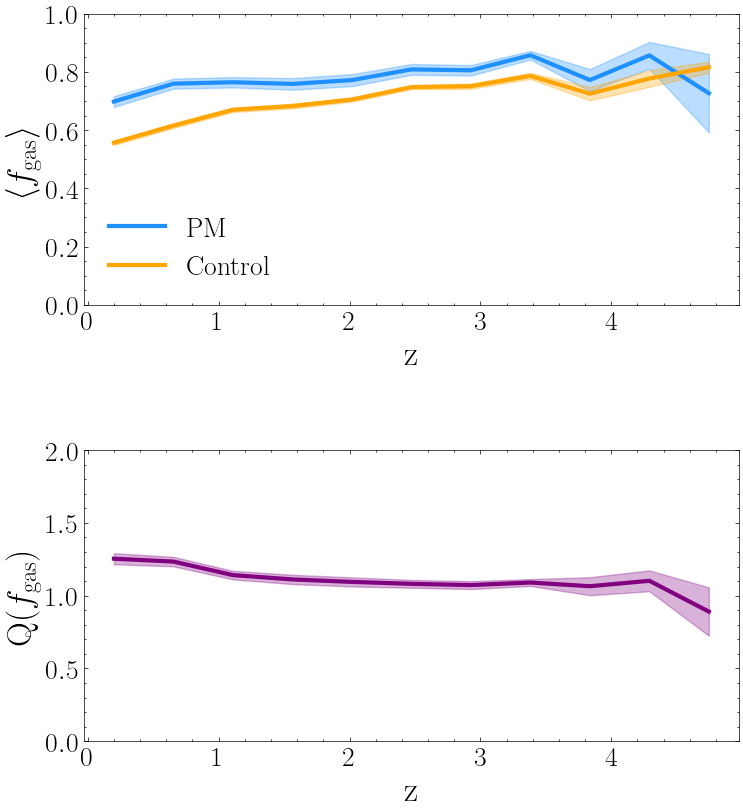

In [21]:
controlpop.set_plot_style(linewidth=3,labelsize=25,ticksize=20,legendsize=20)
fig,axes = controlpop.fgas_evolution(z_min=0, z_max=5, z_binsize=0.4)
fig.set_size_inches(8,9)
axes[0].set_ylim(0,1)
axes[1].set_ylim(0,2)
figure_loc = '../figures/fgas_z_evolution_merger_vs_control.pdf'
fig.savefig(figure_loc)

In [22]:
print("The enhancement in sSFR is %1.3f +/- %1.3f"%(np.mean(controlpop.Q_sSFR),np.mean(controlpop.Q_sSFR_SE)))
print("The enhancement in Mdot is %1.3f +/- %1.3f"%(np.mean(controlpop.Q_Mdot),np.mean(controlpop.Q_Mdot_SE)))
print("The enhancement in fgas is %1.3f +/- %1.3f"%(np.mean(controlpop.Q_fgas),np.mean(controlpop.Q_fgas_SE)))

The enhancement in sSFR is 1.540 +/- 0.239
The enhancement in Mdot is 1.673 +/- 0.540
The enhancement in fgas is 1.103 +/- 0.049


## Calculating dMdot and dSFR


#### $\Delta M_{dot} = \log(M_{dot}(PM)) - median(log(M_{dot} (control))$ 

63
97
150
410


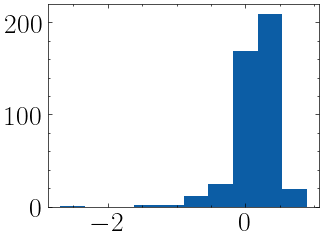

In [85]:
DMgas_dex = []
for i in range(Nmergers):
    Mgas_increment = np.log10(controlpop.pop['merging_population']['Mgas'][controlpop.valid_post_merger_masks][i]) - np.median(np.log10(controlpop.pop['non_merging_population']['Mgas'][:][controlpop.control_indices[:,i]]))
    
    DMgas_dex.append(Mgas_increment)
    if Mgas_increment<-1:
        print(i)
        

plt.hist(DMgas_dex,bins=10)
plt.show()

In [14]:
ii = [64,98,152,417]

for i in ii:

    print("Mgas")
    print(np.log10(controlpop.pop['merging_population']['Mgas'][i]), 
        np.log10(controlpop.pop['non_merging_population']['Mgas'][:][controlpop.control_indices[:,i]]))
    print(np.log10(controlpop.pop['merging_population']['Mgas'][i])-np.median(np.log10(controlpop.pop['non_merging_population']['Mgas'][:][controlpop.control_indices[:,i]])))


    print("Mstar")
    print(np.log10(controlpop.pop['merging_population']['Mstar'][i]),
        np.log10(controlpop.pop['non_merging_population']['Mstar'][:][controlpop.control_indices[:,i]]))
    print(np.log10(controlpop.pop['merging_population']['Mstar'][i])-np.median(np.log10(controlpop.pop['non_merging_population']['Mstar'][:][controlpop.control_indices[:,i]])))

    print("SFR")
    print(np.log10(controlpop.pop['merging_population']['SFR'][i]),
        np.log10(controlpop.pop['non_merging_population']['SFR'][:][controlpop.control_indices[:,i]]))
    print(np.log10(controlpop.pop['merging_population']['SFR'][i])-np.median(np.log10(controlpop.pop['non_merging_population']['SFR'][:][controlpop.control_indices[:,i]])))
    


Mgas
9.671674457061572 [10.12339958 10.83965275 11.03446937 10.834016   10.68586235 10.73889231
 10.53095578 10.67405091 10.68094618 10.91182438]
-1.0407028761464279
Mstar
10.186481638486434 [10.18765994 10.19404061 10.19440687 10.17769817 10.19627425 10.19703098
 10.17507672 10.1745899  10.1732357  10.17275903]
0.0038025832089303435
SFR
1.1334655504770232 [1.39053908 1.30513022 1.32334085 1.16675978 1.22898124 1.40773351
 1.13814881 1.07583385 1.15305692 1.51207988]
-0.1335901768770773
Mgas
9.033248989621374 [10.72346619 10.29677498 10.50118696 10.42536021  9.8129528  10.51613126
 10.3699603  10.67741486 10.63410505 10.68439158]
-1.4754101233156103
Mstar
9.619421777695932 [9.62029882 9.62101207 9.62204405 9.61537425 9.61516953 9.61500191
 9.61477133 9.61385017 9.62529475 9.6266161 ]
0.001585243687015847
SFR
0.6610462505864659 [0.90200128 0.75023476 1.00695925 0.79250115 1.07841331 0.66739613
 0.78416328 0.85183585 0.8807275  1.10345472]
-0.20523542485052737
Mgas
9.886255358680513 [11.

437


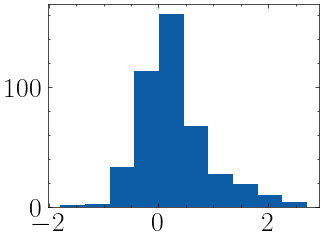

In [65]:
DMdot_dex = []
print(Nmergers)
for i in range(Nmergers):

    PM_mdot = np.log10(controlpop.pop['merging_population']['Mdot'][controlpop.valid_post_merger_masks][i])
    Non_merging_mdot = np.log10(controlpop.pop['non_merging_population']['Mdot'][:][controlpop.control_indices[:,i]])
    
    Mdot_increment = PM_mdot - np.median(Non_merging_mdot)
    DMdot_dex.append(Mdot_increment)

plt.hist(DMdot_dex,bins=10)
plt.show()

In [55]:
Mgas_max = 12.5
Mgas_min = 7.5
Mgas_binsize = 0.7
Nbins_Mgas = int((Mgas_max-Mgas_min)/Mgas_binsize)
Mgas_bins = np.linspace(Mgas_min,Mgas_max,Nbins_Mgas+1)

DMdot_dex_array = np.array(DMdot_dex)
DMdot_dex_median_Mgas = []
DMdot_dex_median_error_Mgas = []

for i in range(len(Mgas_bins)-1):
    merger_bin_mask = (np.log10(controlpop.pop['merging_population']['Mgas'][controlpop.valid_post_merger_masks]) >= Mgas_bins[i]) & (np.log10(controlpop.pop['merging_population']['Mgas'][controlpop.valid_post_merger_masks]) < Mgas_bins[i+1])
    DMdot_dex_median_Mgas.append(np.median(DMdot_dex_array[merger_bin_mask]))
    DMdot_dex_median_error_Mgas.append(np.std(DMdot_dex_array[merger_bin_mask])/np.sqrt(np.sum(merger_bin_mask)))


z_max = 5.0  
z_min = 0.0  
z_binsize = 0.6  
Nbins_z = int((z_max - z_min) / z_binsize)
z_bins = np.linspace(z_min, z_max, Nbins_z + 1)

DMdot_dex_array = np.array(DMdot_dex)
DMdot_dex_median_z = []
DMdot_dex_median_error_z = []

for i in range(len(z_bins) - 1):
    merger_bin_mask = (controlpop.pop['merging_population']['z'][controlpop.valid_post_merger_masks] >= z_bins[i]) & \
                      (controlpop.pop['merging_population']['z'][controlpop.valid_post_merger_masks] < z_bins[i + 1])
    DMdot_dex_median_z.append(np.median(DMdot_dex_array[merger_bin_mask]))
    DMdot_dex_median_error_z.append(np.std(DMdot_dex_array[merger_bin_mask]) / np.sqrt(np.sum(merger_bin_mask)))


Mstar_max = 12.0  # Define the maximum stellar mass
Mstar_min = 7.0   # Define the minimum stellar mass
Mstar_binsize = 1  # Define the bin size for stellar mass
Nbins_Mstar = int((Mstar_max - Mstar_min) / Mstar_binsize)
Mstar_bins = np.linspace(Mstar_min, Mstar_max, Nbins_Mstar + 1)

DMdot_dex_median_Mstar = []
DMdot_dex_median_error_Mstar = []

for i in range(len(Mstar_bins) - 1):
    merger_bin_mask = (np.log10(controlpop.pop['merging_population']['Mstar'][controlpop.valid_post_merger_masks]) >= Mstar_bins[i]) & \
                      (np.log10(controlpop.pop['merging_population']['Mstar'][controlpop.valid_post_merger_masks]) < Mstar_bins[i + 1])
    DMdot_dex_median_Mstar.append(np.median(DMdot_dex_array[merger_bin_mask]))
    DMdot_dex_median_error_Mstar.append(np.std(DMdot_dex_array[merger_bin_mask]) / np.sqrt(np.sum(merger_bin_mask)))


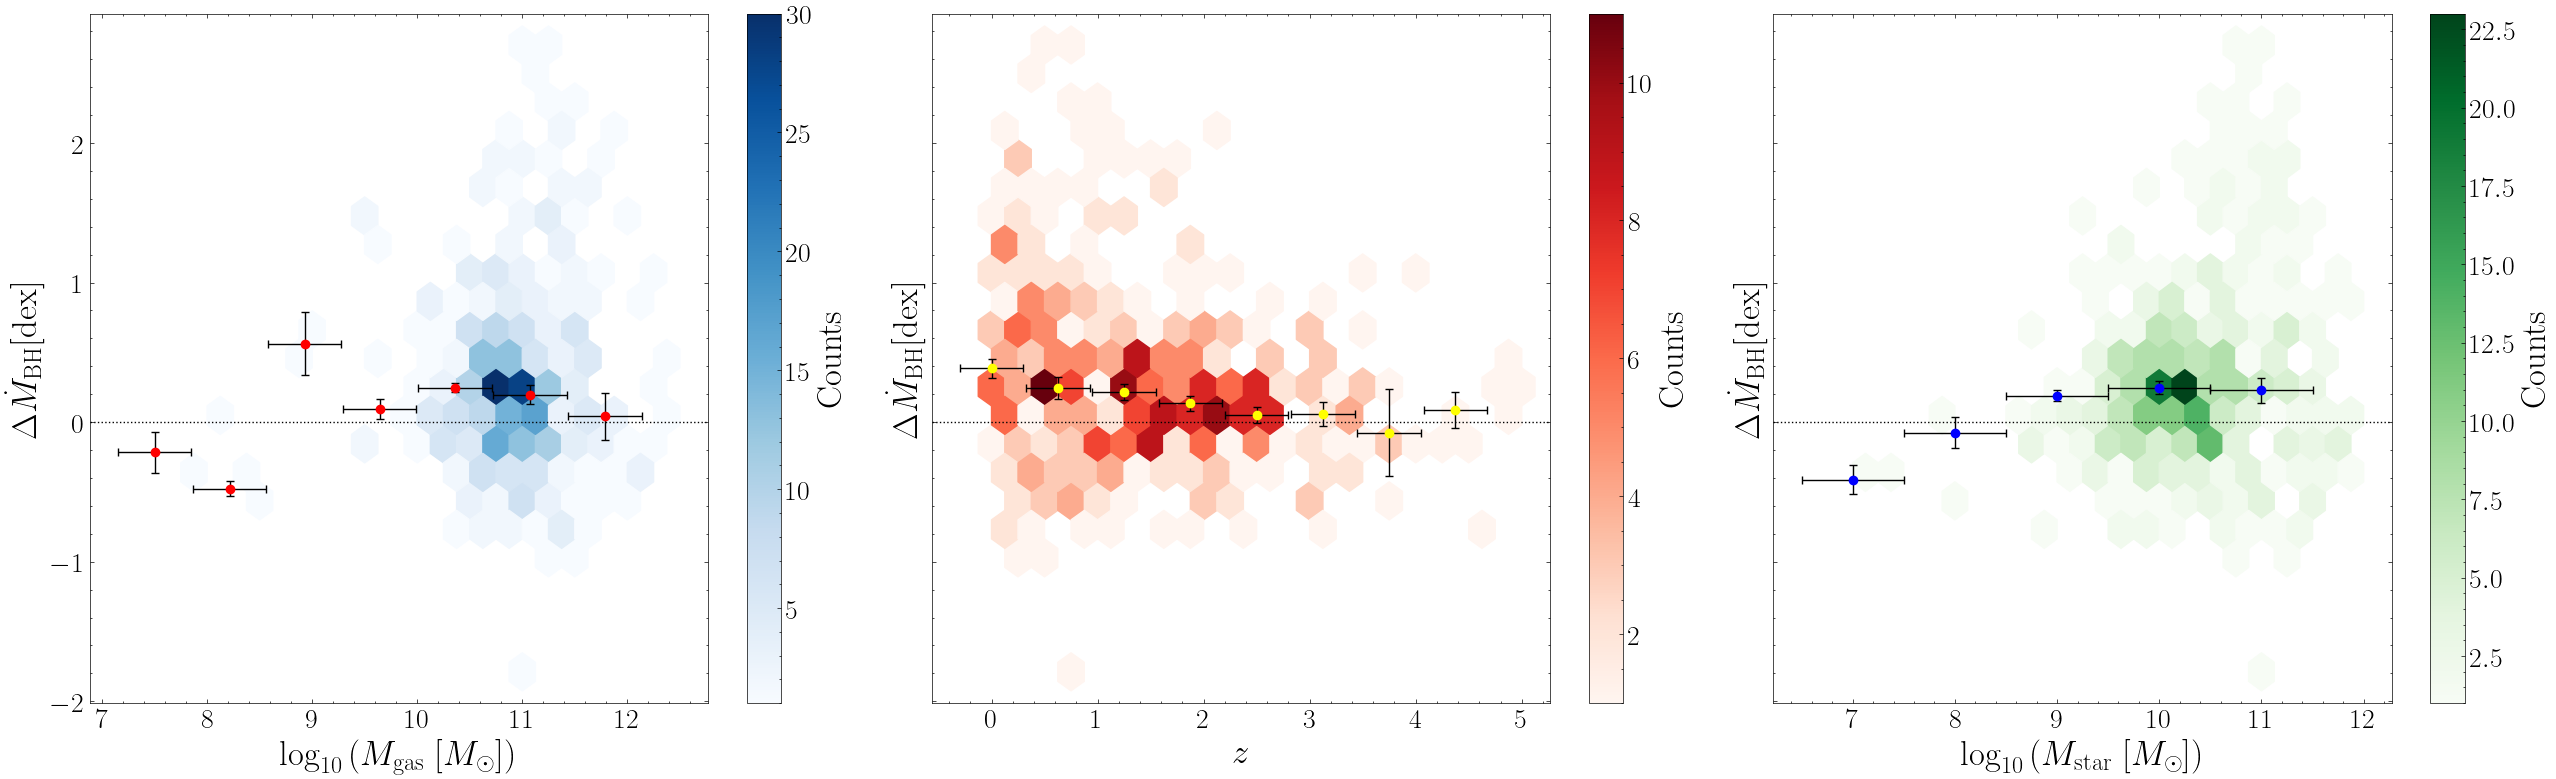

In [58]:
controlpop.set_plot_style(linewidth=3,labelsize=25,ticksize=20,legendsize=20)
fig, axes = plt.subplots(1, 3, figsize=(26, 8), sharey=True)

hex_plot1 = axes[0].hexbin(
    np.log10(controlpop.pop['merging_population']['Mgas'][controlpop.valid_post_merger_masks]),
    DMdot_dex,
    gridsize=20,
    cmap='Blues',
    mincnt=1,
    extent=(Mgas_min, Mgas_max, np.min(DMdot_dex), np.max(DMdot_dex))
)
cbar1 = fig.colorbar(hex_plot1, ax=axes[0])
cbar1.set_label('Counts')
axes[0].errorbar(
    Mgas_bins[:-1],
    DMdot_dex_median_Mgas,
    yerr=DMdot_dex_median_error_Mgas,
    xerr=Mgas_binsize / 2,
    fmt='o',
    color='red',
    ecolor='black',
    elinewidth=1,
    capsize=3
)
axes[0].set_xlabel(r'$\log_{10} \left( M_{\mathrm{gas}} \; [M_{\odot}] \right)$')
axes[0].set_ylabel(r'$\Delta  \dot{M}_{\mathrm{BH}} [\rm dex]$')
axes[0].axhline(0, color='black', linestyle='dotted', linewidth=1)

hex_plot2 = axes[1].hexbin(
    controlpop.pop['merging_population']['z'][controlpop.valid_post_merger_masks],
    DMdot_dex,
    gridsize=20,
    cmap='Reds',
    mincnt=1,
    extent=(z_min, z_max, np.min(DMdot_dex), np.max(DMdot_dex))
)
cbar2 = fig.colorbar(hex_plot2, ax=axes[1])
cbar2.set_label('Counts')
axes[1].errorbar(
    z_bins[:-1],
    DMdot_dex_median_z,
    yerr=DMdot_dex_median_error_z,
    xerr=z_binsize / 2,
    fmt='o',
    color='yellow',
    ecolor='black',
    elinewidth=1,
    capsize=3
)
axes[1].set_xlabel(r'$z$')
axes[1].axhline(0, color='black', linestyle='dotted', linewidth=1)
axes[1].set_ylabel(r'$\Delta  \dot{M}_{\mathrm{BH}} [\rm dex]$')

hex_plot3 = axes[2].hexbin(
    np.log10(controlpop.pop['merging_population']['Mstar'][controlpop.valid_post_merger_masks]),
    DMdot_dex,
    gridsize=20,
    cmap='Greens',
    mincnt=1,
    extent=(Mstar_min, Mstar_max, np.min(DMdot_dex), np.max(DMdot_dex))
)
cbar3 = fig.colorbar(hex_plot3, ax=axes[2])
cbar3.set_label('Counts')
axes[2].errorbar(
    Mstar_bins[:-1],
    DMdot_dex_median_Mstar,
    yerr=DMdot_dex_median_error_Mstar,
    xerr=Mstar_binsize / 2,
    fmt='o',
    color='blue',
    ecolor='black',
    elinewidth=1,
    capsize=3
)
axes[2].set_xlabel(r'$\log_{10} \left( M_{\mathrm{star}} \; [M_{\odot}] \right)$')
axes[2].axhline(0, color='black', linestyle='dotted', linewidth=1)
axes[2].set_ylabel(r'$\Delta  \dot{M}_{\mathrm{BH}} [\rm dex]$')

fig.tight_layout()

/tmp/ipykernel_2027999/1314723065.py:5: RuntimeWarning: divide by zero encountered in log10
  Non_merging_SFR = np.log10(controlpop.pop['non_merging_population']['SFR'][:][controlpop.control_indices[:, i]])


423


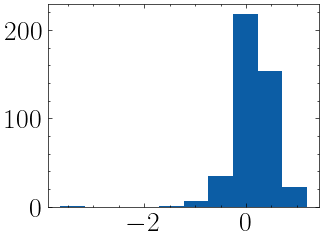

In [ ]:
dSFR_dex = []
for i in range(Nmergers):
    
    PM_SFR = np.log10(controlpop.pop['merging_population']['SFR'][controlpop.valid_post_merger_masks][i])
    Non_merging_SFR = np.log10(controlpop.pop['non_merging_population']['SFR'][:][controlpop.control_indices[:, i]])
    Non_merging_SFR[Non_merging_SFR==np.inf] = 0
    
    SFR_increment = PM_SFR - np.median(Non_merging_SFR)
    dSFR_dex.append(SFR_increment)

plt.hist(dSFR_dex, bins=10)
plt.show()

In [126]:
ii = [430]

for i in ii:

    print("Mgas")
    print(np.log10(controlpop.pop['merging_population']['Mgas'][i]), 
        np.log10(controlpop.pop['non_merging_population']['Mgas'][:][controlpop.control_indices[:,i]]))
    print(np.log10(controlpop.pop['merging_population']['Mgas'][i])-np.median(np.log10(controlpop.pop['non_merging_population']['Mgas'][:][controlpop.control_indices[:,i]])))


    print("Mstar")
    print(np.log10(controlpop.pop['merging_population']['Mstar'][i]),
        np.log10(controlpop.pop['non_merging_population']['Mstar'][:][controlpop.control_indices[:,i]]))
    print(np.log10(controlpop.pop['merging_population']['Mstar'][i])-np.median(np.log10(controlpop.pop['non_merging_population']['Mstar'][:][controlpop.control_indices[:,i]])))

    print("SFR")
    print(np.log10(controlpop.pop['merging_population']['SFR'][i]),
        np.log10(controlpop.pop['non_merging_population']['SFR'][:][controlpop.control_indices[:,i]]))
    print(np.log10(controlpop.pop['merging_population']['SFR'][i])-np.median(np.log10(controlpop.pop['non_merging_population']['SFR'][:][controlpop.control_indices[:,i]])))


Mgas
11.124149406488408 [11.52211153 10.57542755 10.03729936 11.21436059 11.57247856 11.17095872
 11.11300518 11.51977841 11.21837094  9.99495004]
-0.06851024857010835
Mstar
11.269357625369164 [11.27024927 11.26806089 11.27204327 11.26502164 11.26177792 11.27824079
 11.26903699 11.27188906 11.26673024 11.27247145]
-0.0002855058777662123
SFR
-3.2803509305953327 [ 1.02624933  1.24661853 -3.85102493  0.57538467 -0.02937489  0.1915721
 -2.60668631  0.98581624  0.53809852 -4.00073088]
-3.645186242495564


In [76]:
Mgas_max = 12.5
Mgas_min = 7.5
Mgas_binsize = 0.7
Nbins_Mgas = int((Mgas_max - Mgas_min) / Mgas_binsize)
Mgas_bins = np.linspace(Mgas_min, Mgas_max, Nbins_Mgas + 1)

dSFR_dex_array = np.array(dSFR_dex)
dSFR_dex_median_Mgas = []
dSFR_dex_median_error_Mgas = []

for i in range(len(Mgas_bins) - 1):
    merger_bin_mask = (np.log10(controlpop.pop['merging_population']['Mgas'][controlpop.valid_post_merger_masks]) >= Mgas_bins[i]) & \
                      (np.log10(controlpop.pop['merging_population']['Mgas'][controlpop.valid_post_merger_masks]) < Mgas_bins[i + 1])
    dSFR_dex_median_Mgas.append(np.median(dSFR_dex_array[merger_bin_mask]))
    dSFR_dex_median_error_Mgas.append(np.std(dSFR_dex_array[merger_bin_mask]) / np.sqrt(np.sum(merger_bin_mask)))


z_max = 5.0  
z_min = 0.0  
z_binsize = 0.6  
Nbins_z = int((z_max - z_min) / z_binsize)
z_bins = np.linspace(z_min, z_max, Nbins_z + 1)

dSFR_dex_median_z = []
dSFR_dex_median_error_z = []

for i in range(len(z_bins) - 1):
    merger_bin_mask = (controlpop.pop['merging_population']['z'][controlpop.valid_post_merger_masks] >= z_bins[i]) & \
                      (controlpop.pop['merging_population']['z'][controlpop.valid_post_merger_masks] < z_bins[i + 1])
    dSFR_dex_median_z.append(np.median(dSFR_dex_array[merger_bin_mask]))
    dSFR_dex_median_error_z.append(np.std(dSFR_dex_array[merger_bin_mask]) / np.sqrt(np.sum(merger_bin_mask)))


Mstar_max = 12.0  
Mstar_min = 7.0   
Mstar_binsize = 1  
Nbins_Mstar = int((Mstar_max - Mstar_min) / Mstar_binsize)
Mstar_bins = np.linspace(Mstar_min, Mstar_max, Nbins_Mstar + 1)



dSFR_dex_median_Mstar = []
dSFR_dex_median_error_Mstar = []

for i in range(len(Mstar_bins) - 1):
    merger_bin_mask = (np.log10(controlpop.pop['merging_population']['Mstar'][controlpop.valid_post_merger_masks]) >= Mstar_bins[i]) & \
                      (np.log10(controlpop.pop['merging_population']['Mstar'][controlpop.valid_post_merger_masks]) < Mstar_bins[i + 1])
    dSFR_dex_median_Mstar.append(np.median(dSFR_dex_array[merger_bin_mask]))
    dSFR_dex_median_error_Mstar.append(np.std(dSFR_dex_array[merger_bin_mask]) / np.sqrt(np.sum(merger_bin_mask)))


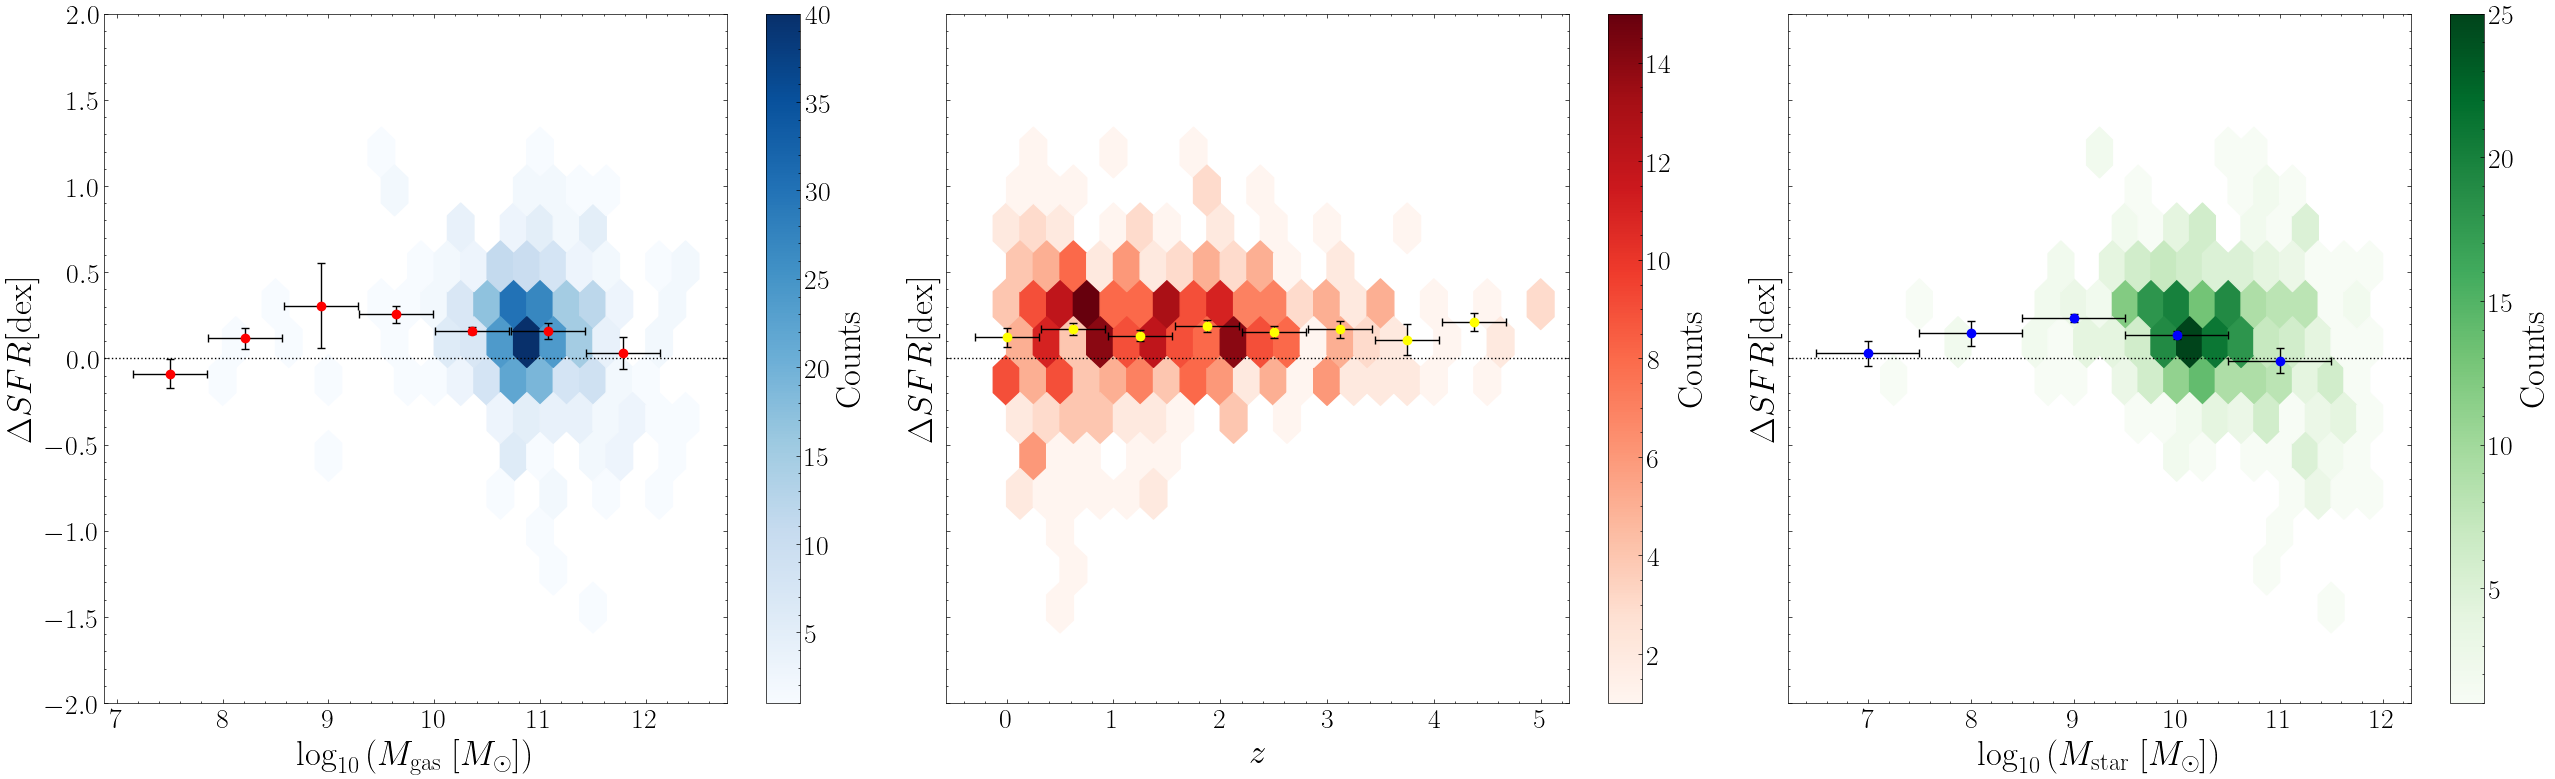

In [77]:
fig, axes = plt.subplots(1, 3, figsize=(26, 8), sharey=True)

hex_plot1 = axes[0].hexbin(
    np.log10(controlpop.pop['merging_population']['Mgas'][controlpop.valid_post_merger_masks]),
    dSFR_dex,
    gridsize=20,
    cmap='Blues',
    mincnt=1,
    extent=(Mgas_min, Mgas_max, np.min(dSFR_dex), np.max(dSFR_dex))
)
cbar1 = fig.colorbar(hex_plot1, ax=axes[0])
cbar1.set_label('Counts')
axes[0].errorbar(
    Mgas_bins[:-1],
    dSFR_dex_median_Mgas,
    yerr=dSFR_dex_median_error_Mgas,
    xerr=Mgas_binsize / 2,
    fmt='o',
    color='red',
    ecolor='black',
    elinewidth=1,
    capsize=3
)
axes[0].set_xlabel(r'$\log_{10} \left( M_{\mathrm{gas}} \; [M_{\odot}] \right)$')
axes[0].set_ylabel(r'$\Delta  SFR [\rm dex]$')
axes[0].set_ylim(-2, 2)
axes[0].axhline(0, color='black', linestyle='dotted', linewidth=1)

hex_plot2 = axes[1].hexbin(
    controlpop.pop['merging_population']['z'][controlpop.valid_post_merger_masks],
    dSFR_dex,
    gridsize=20,
    cmap='Reds',
    mincnt=1,
    extent=(z_min, z_max, np.min(dSFR_dex), np.max(dSFR_dex))
)
cbar2 = fig.colorbar(hex_plot2, ax=axes[1])
cbar2.set_label('Counts')
axes[1].errorbar(
    z_bins[:-1],
    dSFR_dex_median_z,
    yerr=dSFR_dex_median_error_z,
    xerr=z_binsize / 2,
    fmt='o',
    color='yellow',
    ecolor='black',
    elinewidth=1,
    capsize=3
)
axes[1].set_xlabel(r'$z$')
axes[1].set_ylim(-2, 2)
axes[1].axhline(0, color='black', linestyle='dotted', linewidth=1)
axes[1].set_ylabel(r'$\Delta  SFR [\rm dex]$')
hex_plot3 = axes[2].hexbin(
    np.log10(controlpop.pop['merging_population']['Mstar'][controlpop.valid_post_merger_masks]),
    dSFR_dex,
    gridsize=20,
    cmap='Greens',
    mincnt=1,
    extent=(Mstar_min, Mstar_max, np.min(dSFR_dex), np.max(dSFR_dex))
)
cbar3 = fig.colorbar(hex_plot3, ax=axes[2])
cbar3.set_label('Counts')
axes[2].errorbar(
    Mstar_bins[:-1],
    dSFR_dex_median_Mstar,
    yerr=dSFR_dex_median_error_Mstar,
    xerr=Mstar_binsize / 2,
    fmt='o',
    color='blue',
    ecolor='black',
    elinewidth=1,
    capsize=3
)
axes[2].set_xlabel(r'$\log_{10} \left( M_{\mathrm{star}} \; [M_{\odot}] \right)$')
axes[2].set_ylim(-2, 2)
axes[2].axhline(0, color='black', linestyle='dotted', linewidth=1)
axes[2].set_ylabel(r'$\Delta  SFR [\rm dex]$')
fig.tight_layout()


In [82]:
len(dSFR_dex)

437

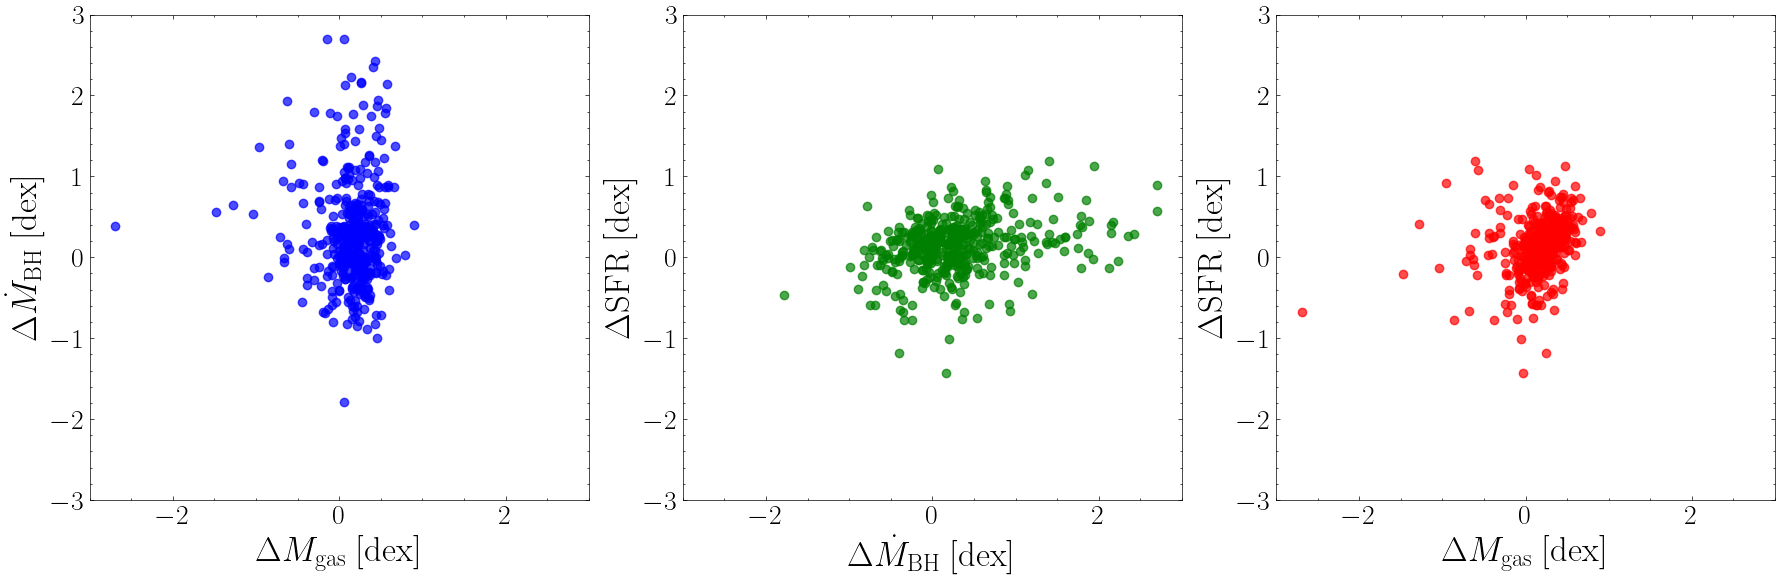

In [87]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Scatter plot: DMdot_dex vs dMgas_dex
axes[0].scatter(DMgas_dex,DMdot_dex, alpha=0.7, color='blue')
axes[0].set_ylabel(r'$\Delta \dot{M}_{\mathrm{BH}} \; [\mathrm{dex}]$')
axes[0].set_xlabel(r'$\Delta M_{\mathrm{gas}} \; [\mathrm{dex}]$')
axes[0].set_xlim(-3, 3)
axes[0].set_ylim(-3, 3)

# Scatter plot: DMdot_dex vs dSFR_dex
axes[1].scatter(DMdot_dex, dSFR_dex, alpha=0.7, color='green')
axes[1].set_xlabel(r'$\Delta \dot{M}_{\mathrm{BH}} \; [\mathrm{dex}]$')
axes[1].set_ylabel(r'$\Delta \mathrm{SFR} \; [\mathrm{dex}]$')
axes[1].set_xlim(-3, 3)
axes[1].set_ylim(-3, 3)


# Scatter plot: dMgas_dex vs dSFR_dex
axes[2].scatter(DMgas_dex, dSFR_dex, alpha=0.7, color='red')
axes[2].set_xlabel(r'$\Delta M_{\mathrm{gas}} \; [\mathrm{dex}]$')
axes[2].set_ylabel(r'$\Delta \mathrm{SFR} \; [\mathrm{dex}]$')
axes[2].set_xlim(-3, 3)
axes[2].set_ylim(-3, 3)

# Adjust layout
plt.tight_layout()
plt.show()